# How to spatially interpolate (Makkink) Evaporation?

Does interpolation matter? There are ways to interpolate evaporation datasets. However currently the nearest station is always used for modeling. Does this give different results? First lets look spatially.

Martin Vonk - 2022

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator, NearestNDInterpolator

import hydropandas as hpd
import hydropandas.io.io_knmi as hpdio
import art_tools as at

%load_ext autoreload
%autoreload 2

Get all stations where EV24 is measured

In [2]:
stns = hpdio.get_stations(meteo_var='EV24').sort_index()

Collect all EV24 data ever measured by KNMI

In [3]:
tmin = '1900'
tmax = '2022-04-11'

# empty dataframe
df = pd.DataFrame(columns=stns.index, index=pd.date_range(start=tmin,
                                                          end=tmax, 
                                                          freq='H'))

for stn in tqdm(stns.index):
    df_stn = hpd.MeteoObs.from_knmi(stn, meteo_var='EV24',
                                    fill_missing_obs=False, 
                                    startdate=tmin, enddate=tmax)
    df[stn] = df_stn

# drop emtpy hours
df = df.dropna(how='all').copy()

100%|██████████| 34/34 [00:20<00:00,  1.63it/s]


In [4]:
df

210     215     235     240  242     249     251     257  \
1957-07-02 01:00:00  NaN     NaN     NaN     NaN  NaN     NaN     NaN     NaN   
1957-07-03 01:00:00  NaN     NaN     NaN     NaN  NaN     NaN     NaN     NaN   
1957-07-04 01:00:00  NaN     NaN     NaN     NaN  NaN     NaN     NaN     NaN   
1957-07-05 01:00:00  NaN     NaN     NaN     NaN  NaN     NaN     NaN     NaN   
1957-07-06 01:00:00  NaN     NaN     NaN     NaN  NaN     NaN     NaN     NaN   
...                  ...     ...     ...     ...  ...     ...     ...     ...   
2022-04-06 01:00:00  NaN  0.0010  0.0009  0.0008  NaN  0.0008  0.0009  0.0009   
2022-04-07 01:00:00  NaN  0.0009  0.0014  0.0007  NaN  0.0012  0.0015  0.0011   
2022-04-08 01:00:00  NaN  0.0016  0.0015  0.0018  NaN  0.0015  0.0017  0.0016   
2022-04-09 01:00:00  NaN  0.0015  0.0022  0.0016  NaN  0.0018  0.0023  0.0019   
2022-04-10 01:00:00  NaN  0.0018  0.0019  0.0016  NaN  0.0018  0.0020  0.0021   

                        260     267  ...     330     344     348     350  \
1957-07-02 01:00:00  0.0036     NaN  ...     NaN     NaN     NaN     NaN   
1957-07-03 01:00:00  0.0042     NaN  ...     NaN     NaN     NaN     NaN   
1957-07-04 01:00:00  0.0033     NaN  ...     NaN     NaN     NaN     NaN   
1957-07-05 01:00:00  0.0038     NaN  ...     NaN     NaN     NaN     NaN   
1957-07-06 01:00:00  0.0037     NaN  ...     NaN     NaN     NaN     NaN   
...                     ...     ...  ...     ...     ...     ...     ...   
2022-04-06 01:00:00  0.0007  0.0009  ...  0.0010  0.0008  0.0007  0.0008   
2022-04-07 01:00:00  0.0006  0.0012  ...  0.0009  0.0006  0.0006  0.0006   
2022-04-08 01:00:00  0.0011  0.0016  ...  0.0019  0.0017  0.0014  0.0017   
2022-04-09 01:00:00  0.0014  0.0022  ...  0.0015  0.0014  0.0014  0.0011   
2022-04-10 01:00:00  0.0019  0.0018  ...  0.0027  0.0021  0.0018     NaN   

                        356     370     375     377     380     391  
1957-07-02 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
1957-07-03 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
1957-07-04 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
1957-07-05 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
1957-07-06 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
...                     ...     ...     ...     ...     ...     ...  
2022-04-06 01:00:00  0.0007  0.0008  0.0007  0.0007  0.0006  0.0007  
2022-04-07 01:00:00  0.0006  0.0006  0.0005  0.0007  0.0007  0.0005  
2022-04-08 01:00:00  0.0017  0.0015  0.0013  0.0016  0.0018  0.0015  
2022-04-09 01:00:00  0.0013  0.0011  0.0012  0.0010  0.0008  0.0012  
2022-04-10 01:00:00  0.0020  0.0019  0.0019  0.0020  0.0018  0.0018  

[23659 rows x 34 columns]

Collect shape of NL

In [4]:
nl = at.shapes.nederland().boundary

According to the KNMI, thin plate spline is the best way to interpolate Makkink evaporation. Thats also how they provide the gridded Makkink evaporation : 

- [Evaporation Dataset - gridded daily Makkink evaporation for the Netherlands](https://dataplatform.knmi.nl/dataset/ev24-2)
- [Interpolation of Makkink evaporation in the
Netherlands - Paul Hiemstra and Raymond Sluiter (2011)](https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubTR/TR327.pdf)

100%|██████████| 65/65 [00:14<00:00,  4.40it/s]


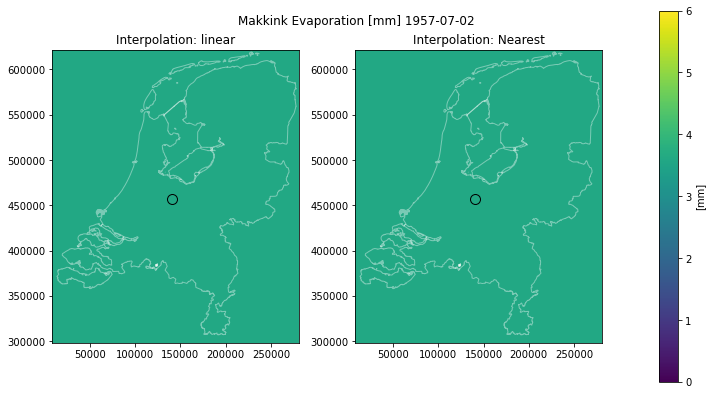

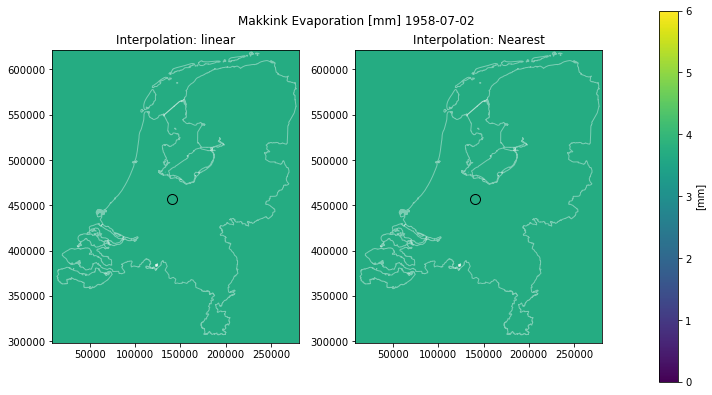

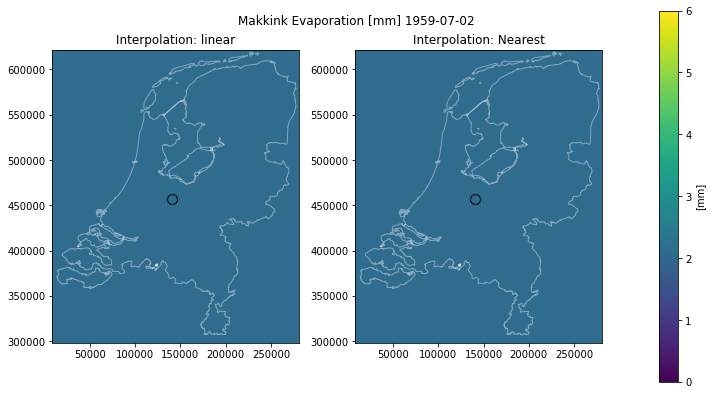

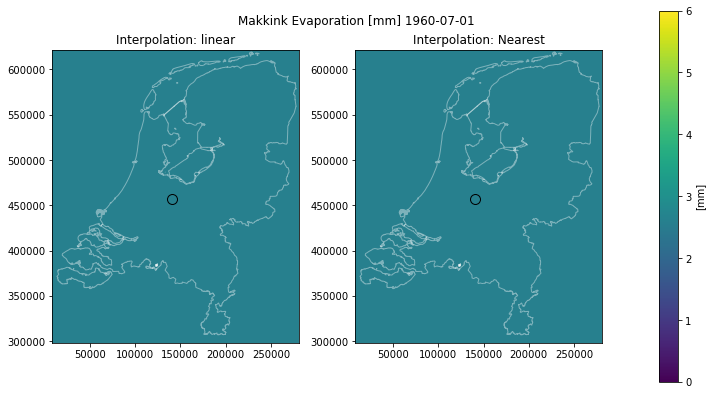

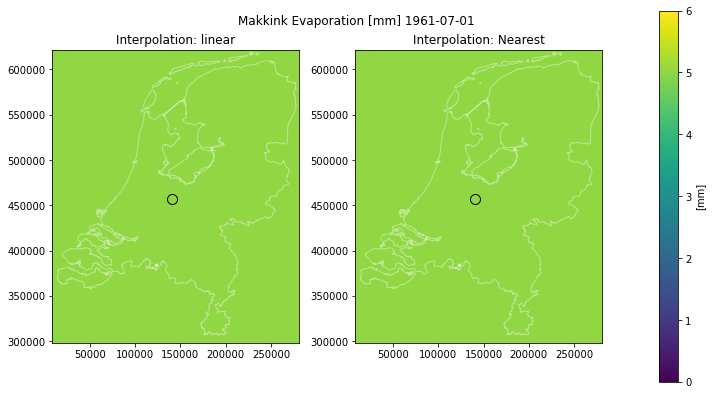

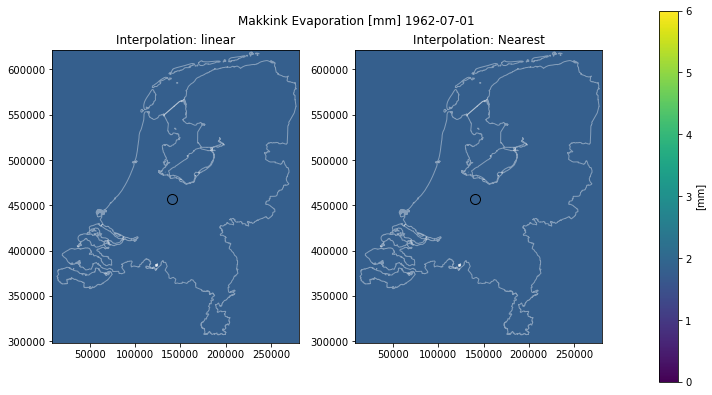

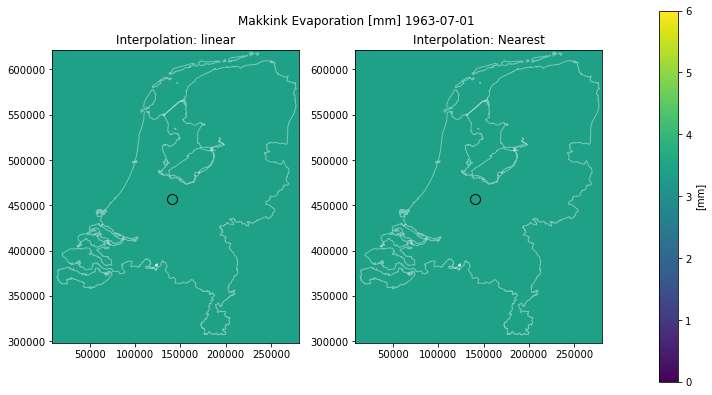

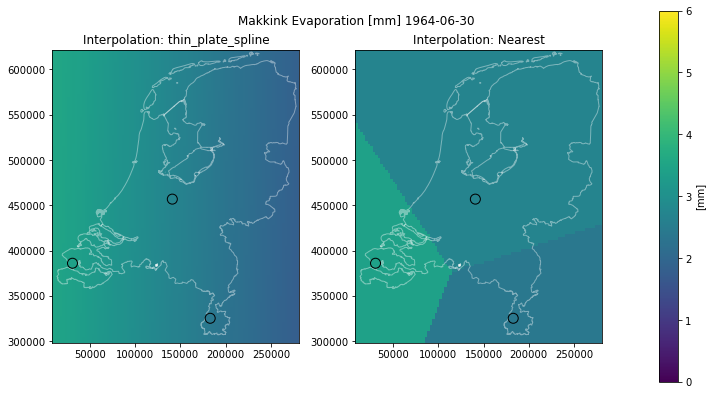

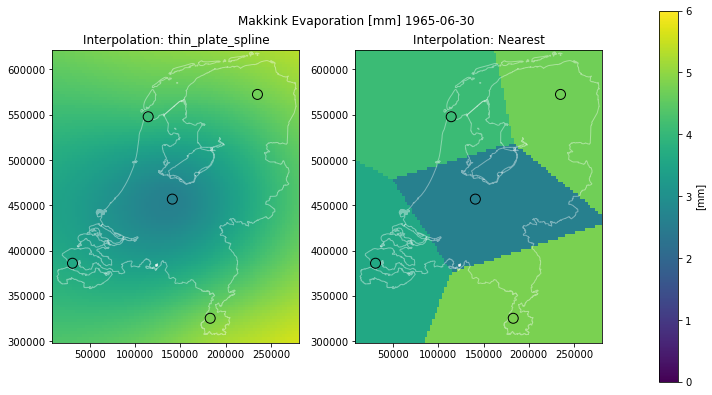

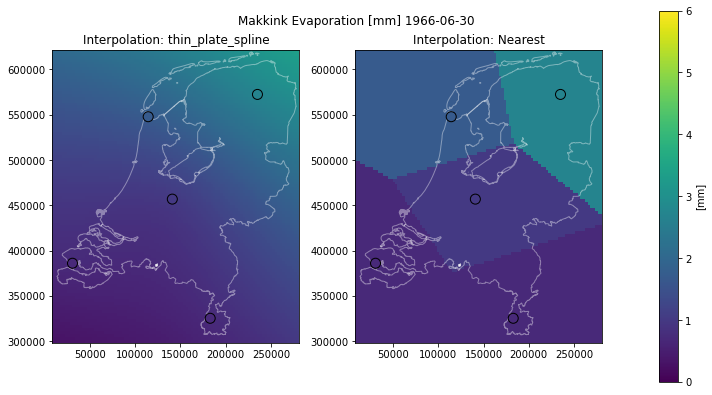

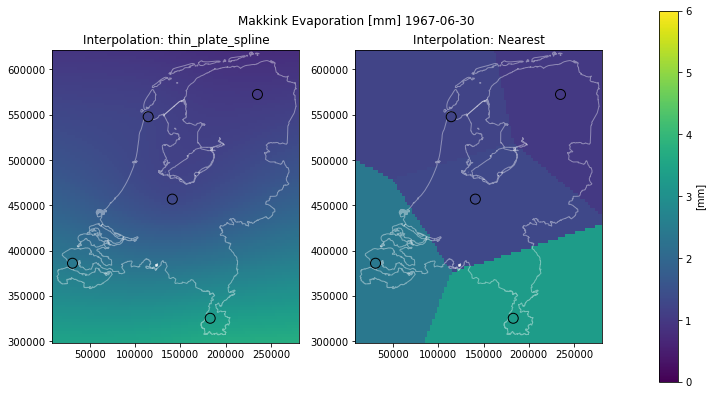

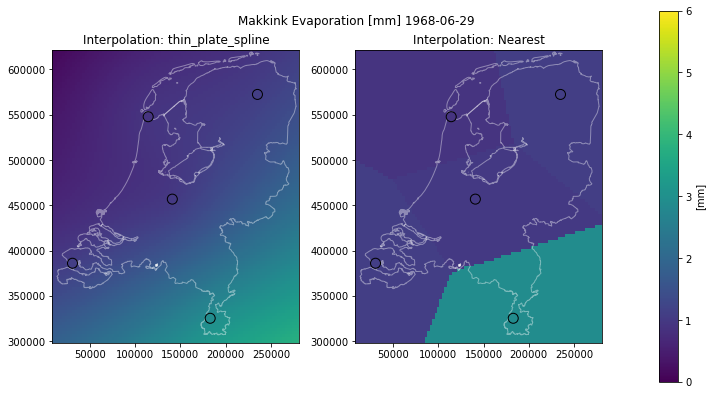

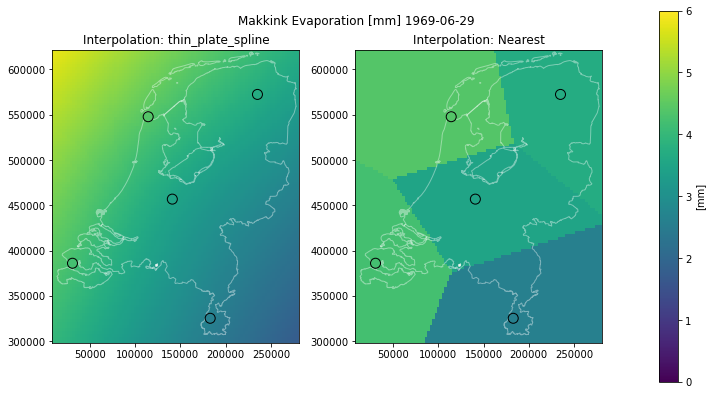

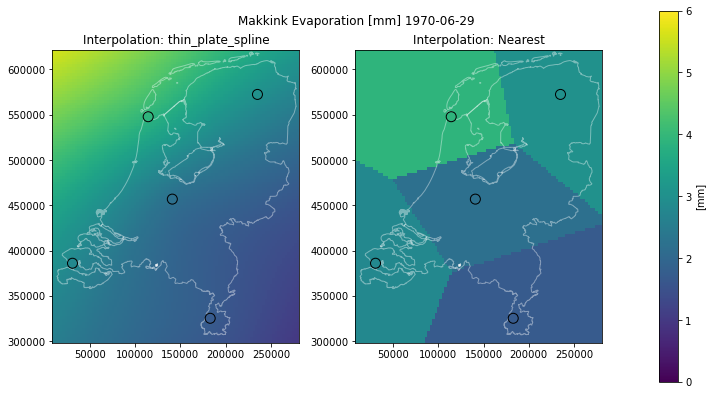

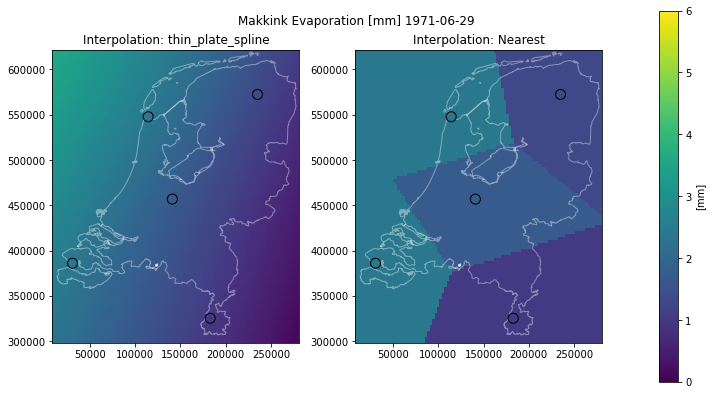

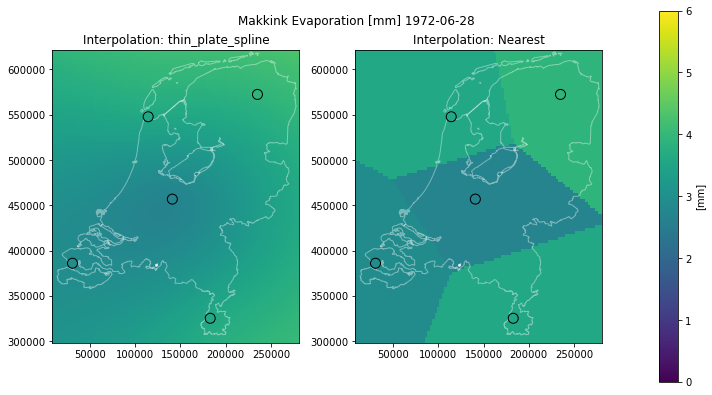

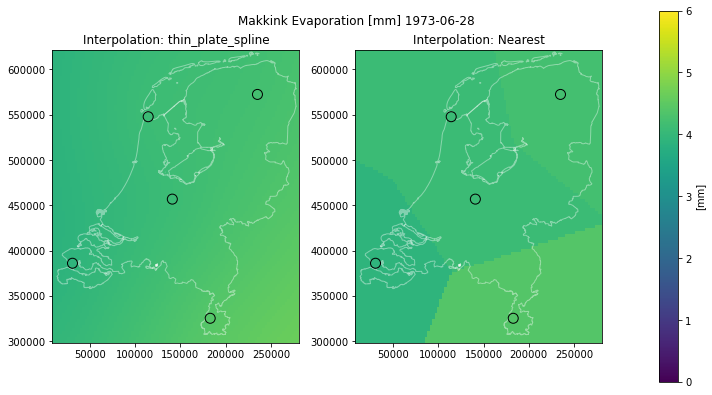

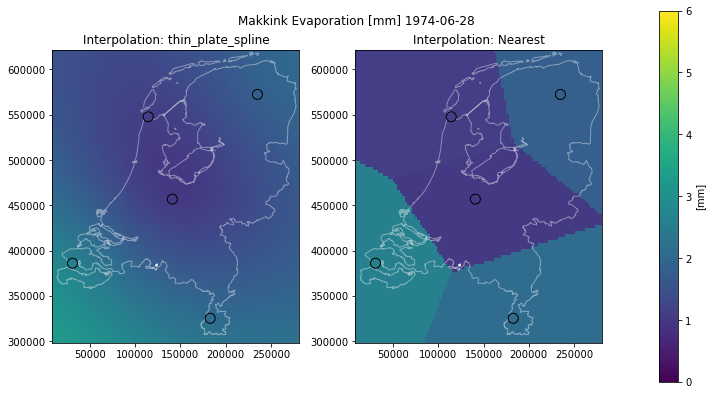

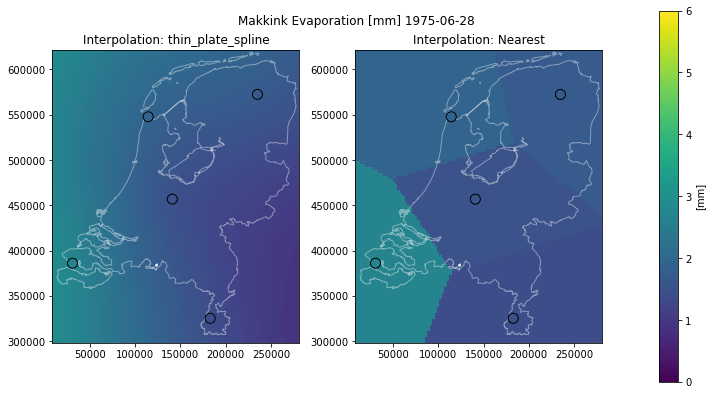

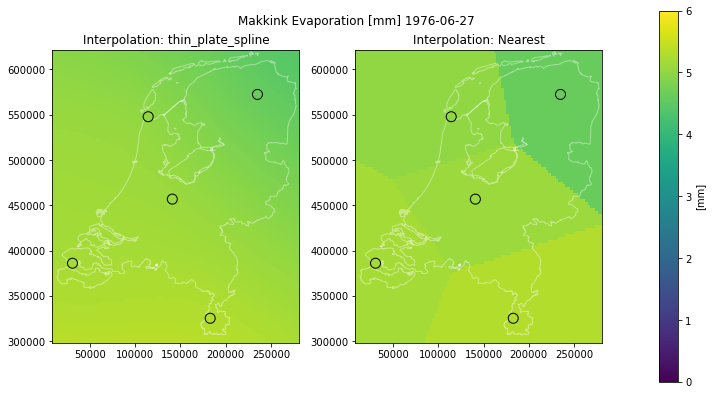

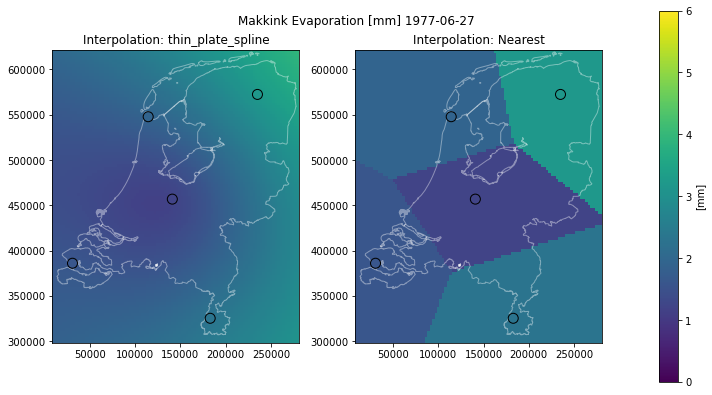

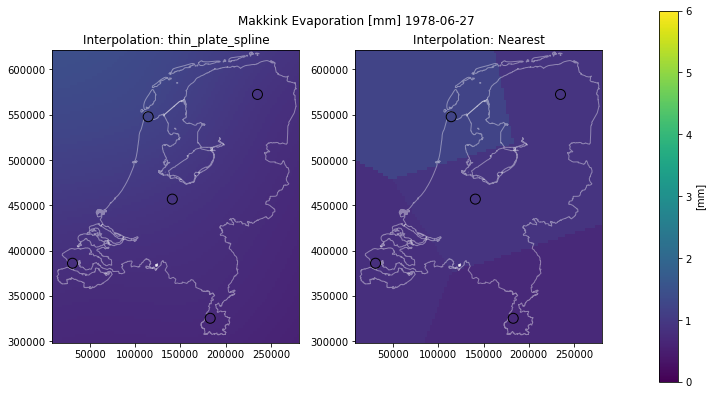

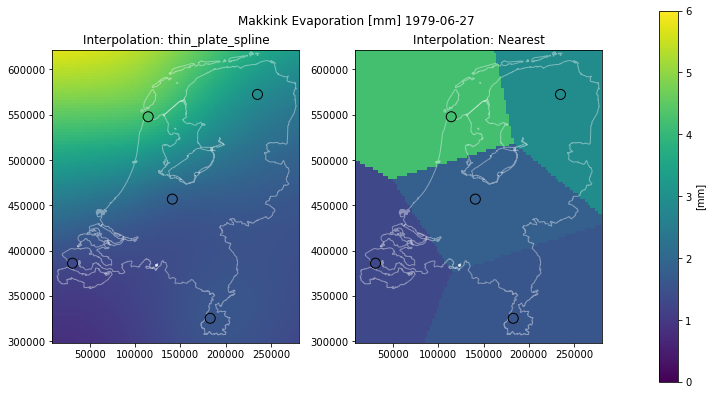

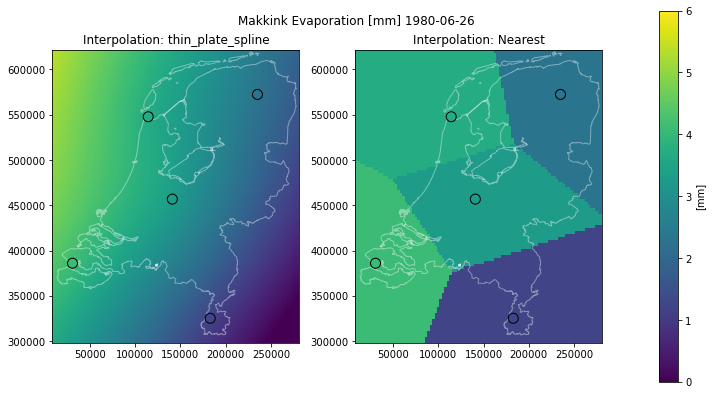

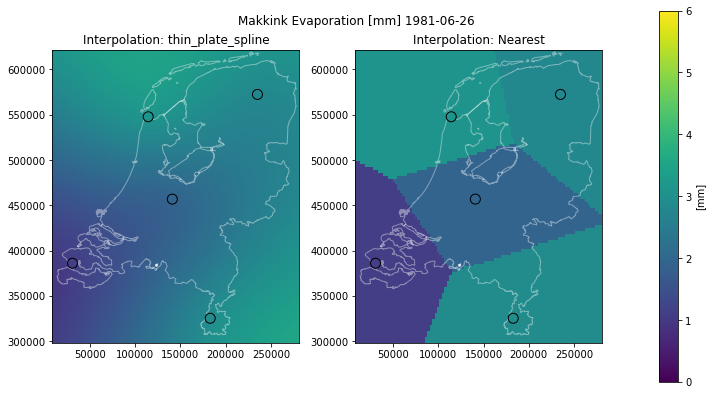

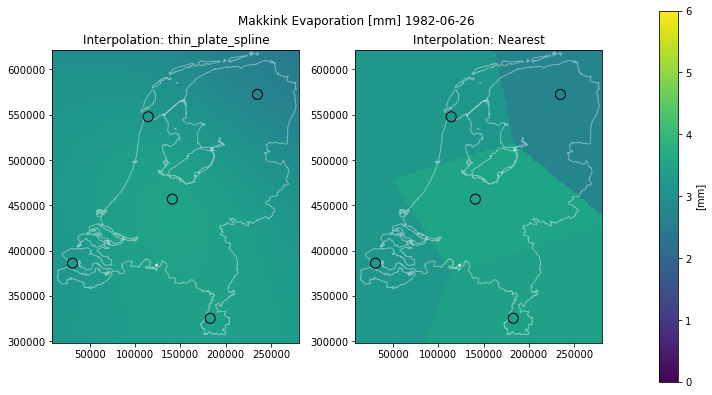

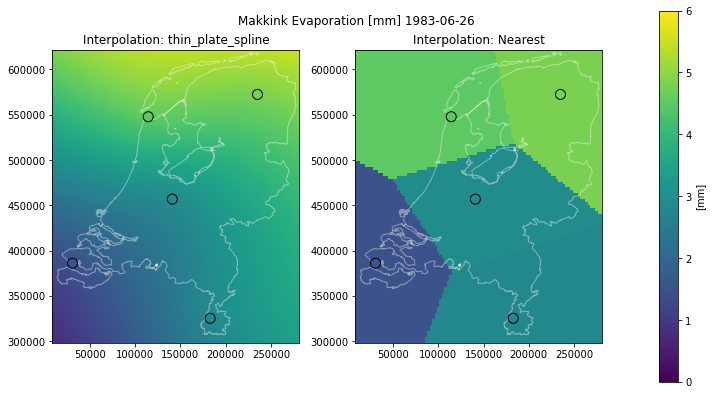

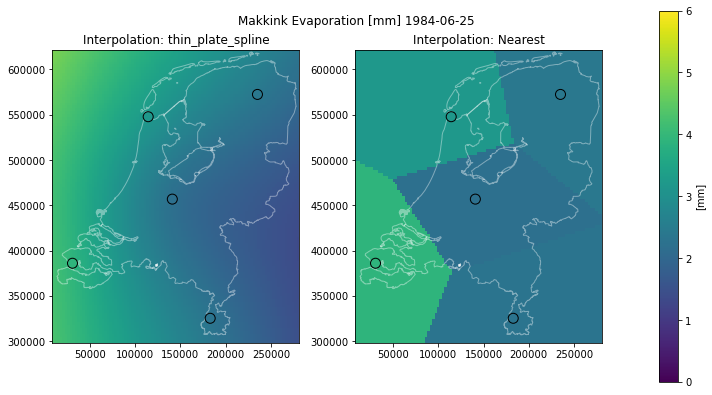

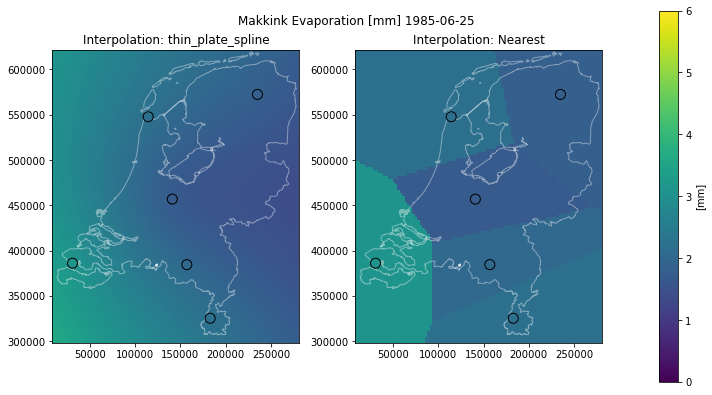

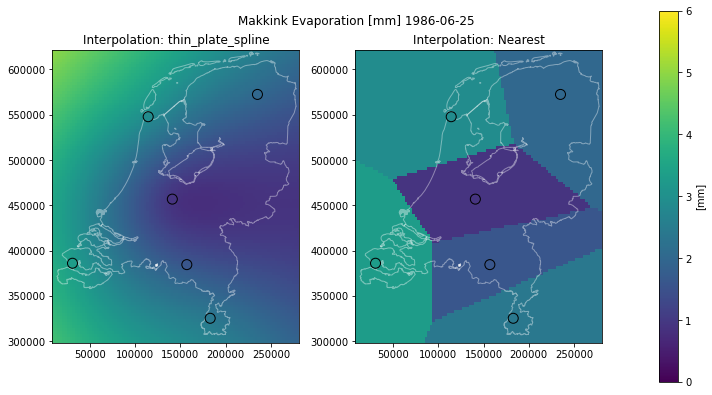

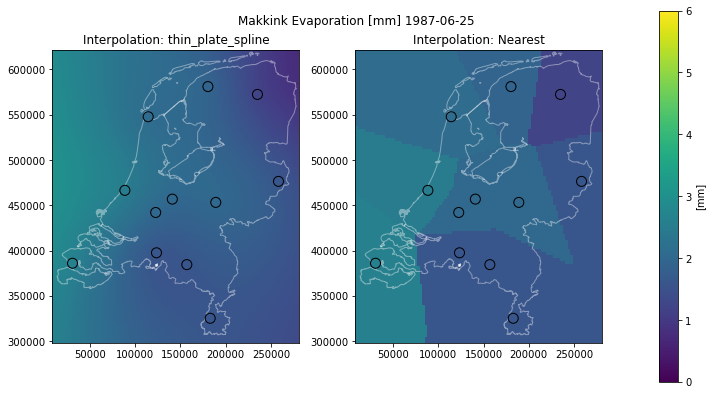

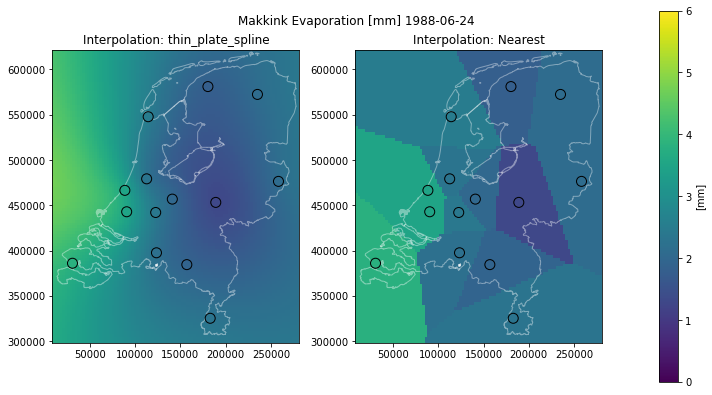

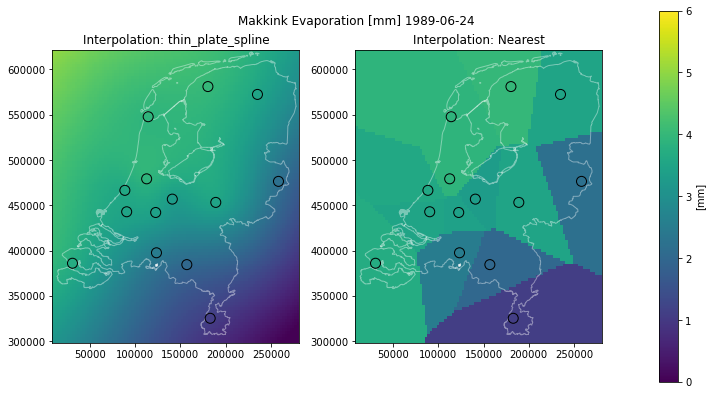

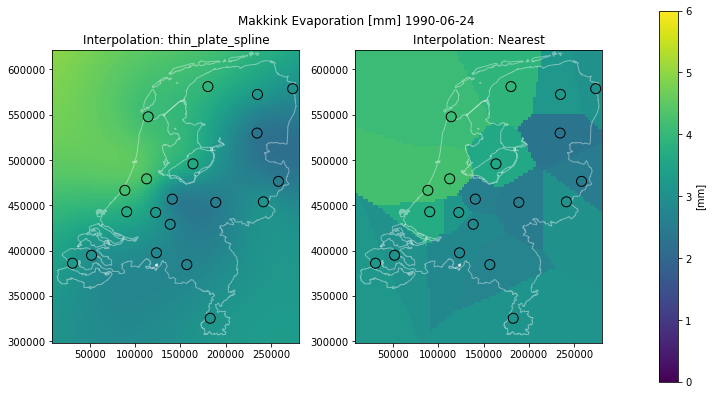

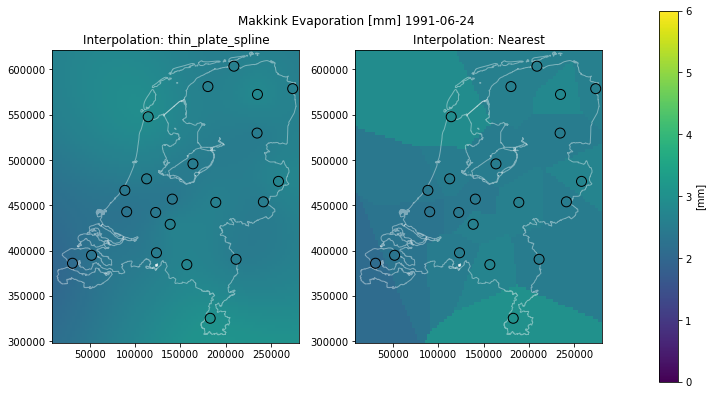

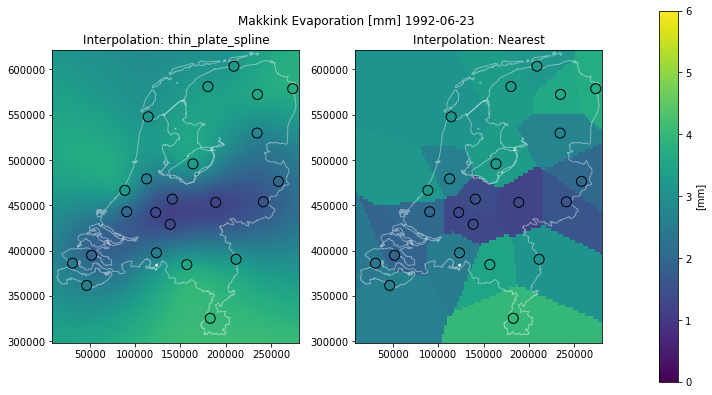

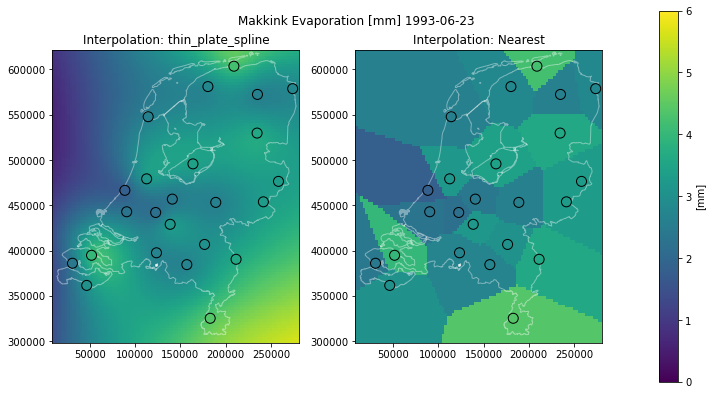

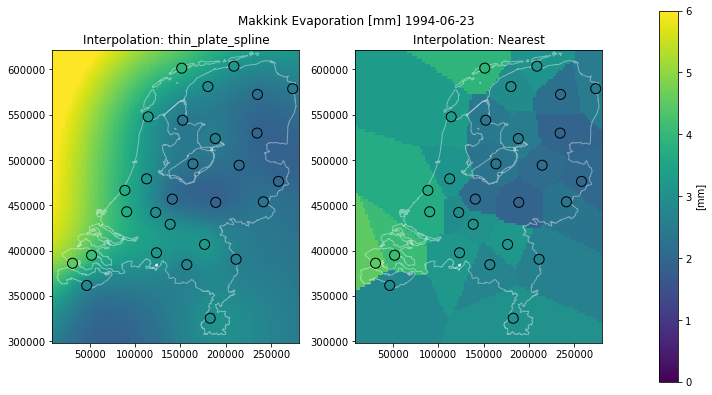

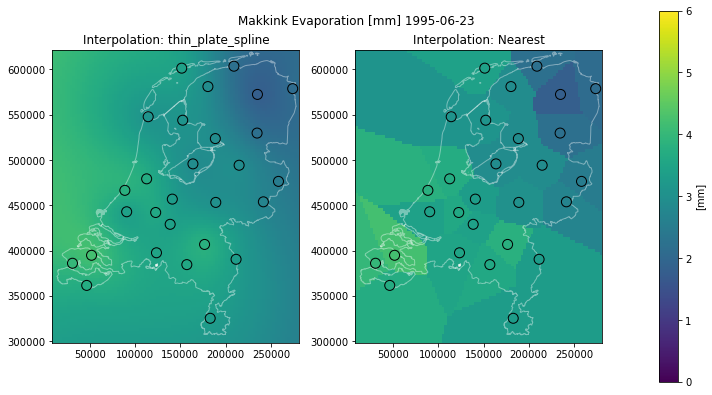

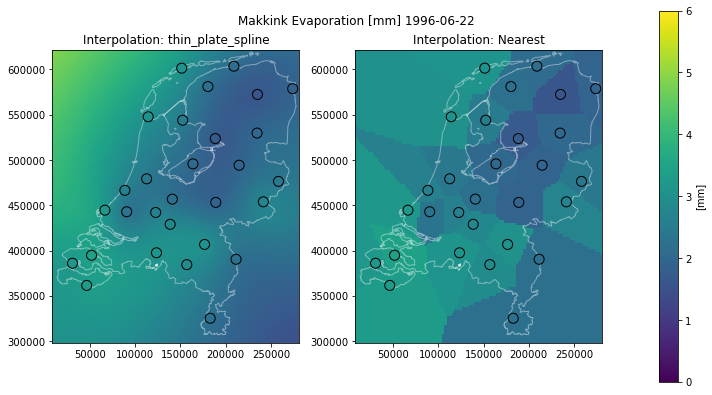

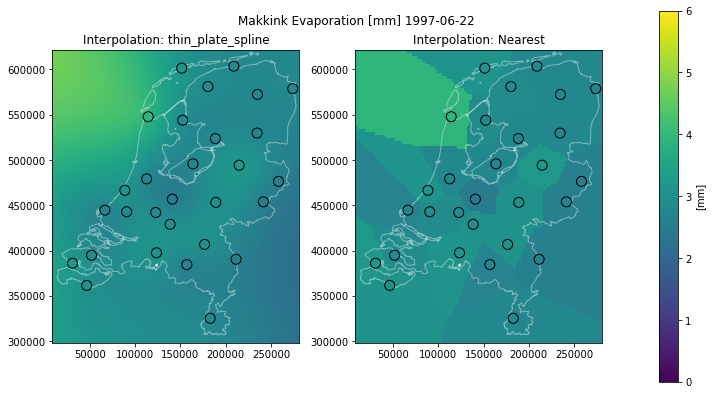

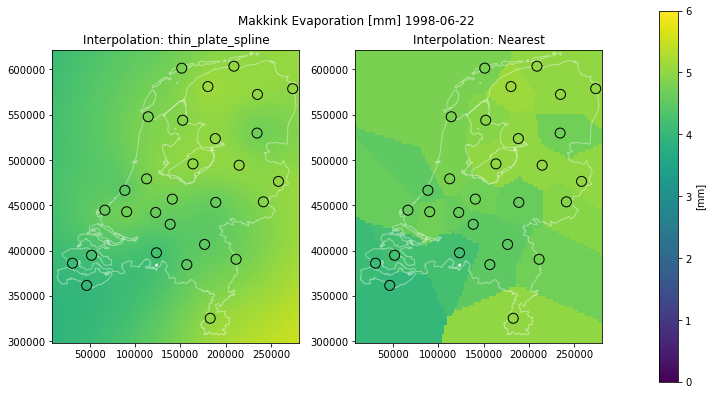

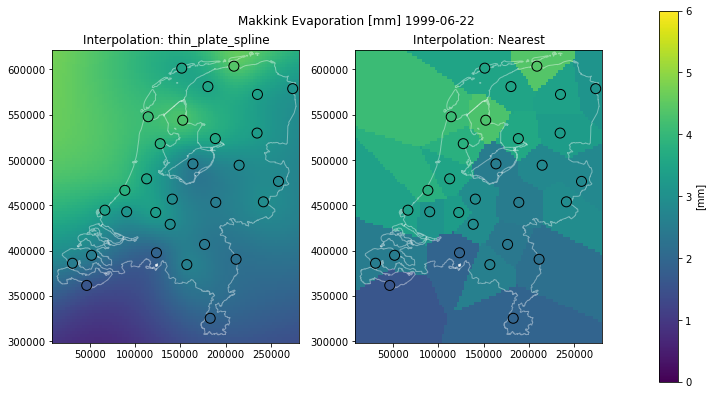

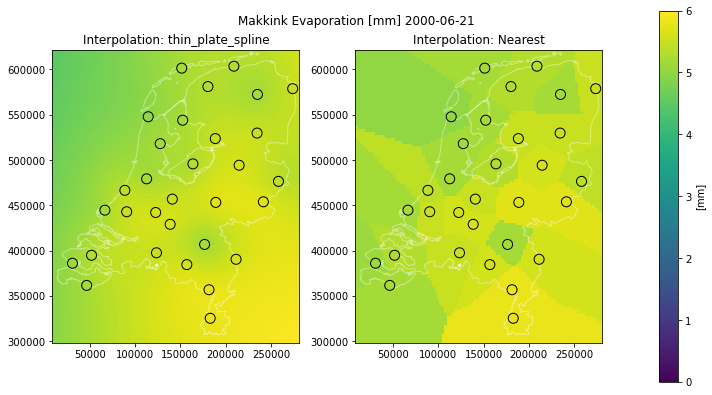

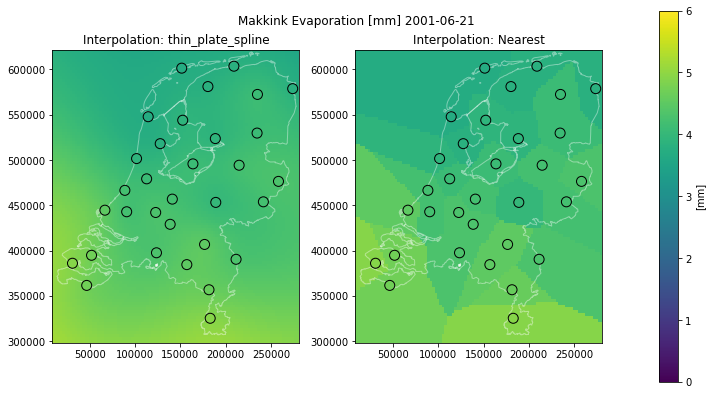

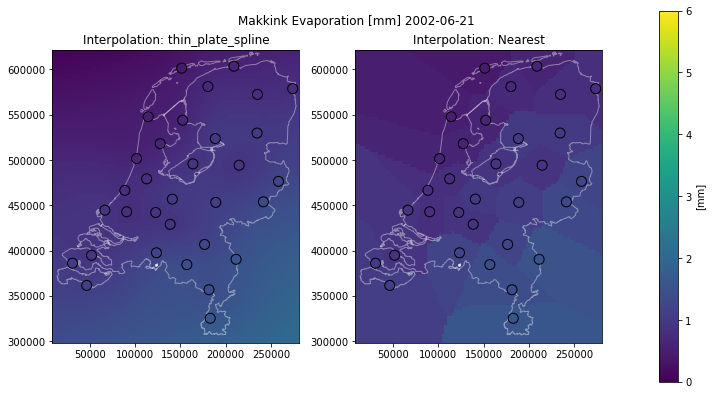

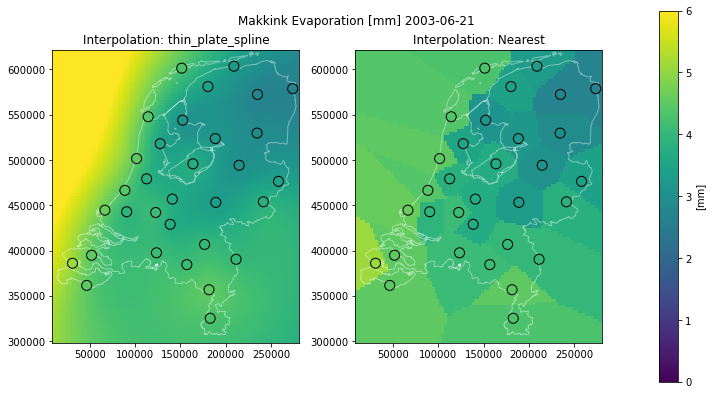

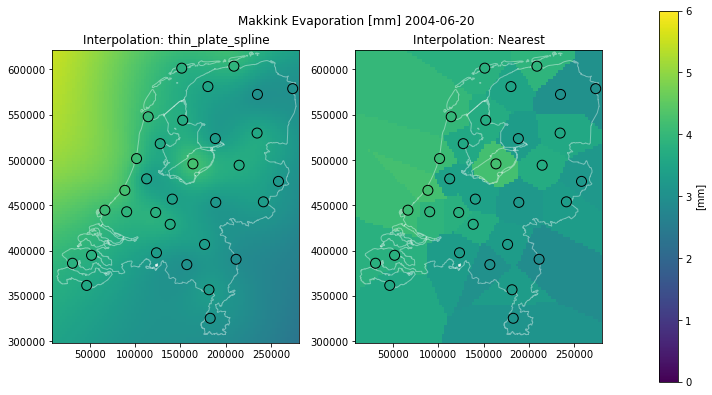

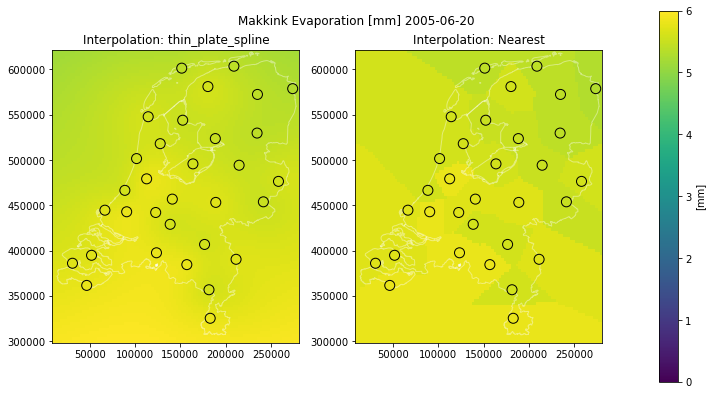

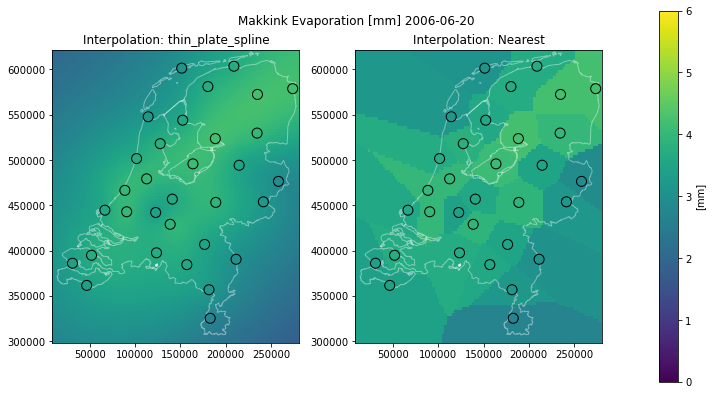

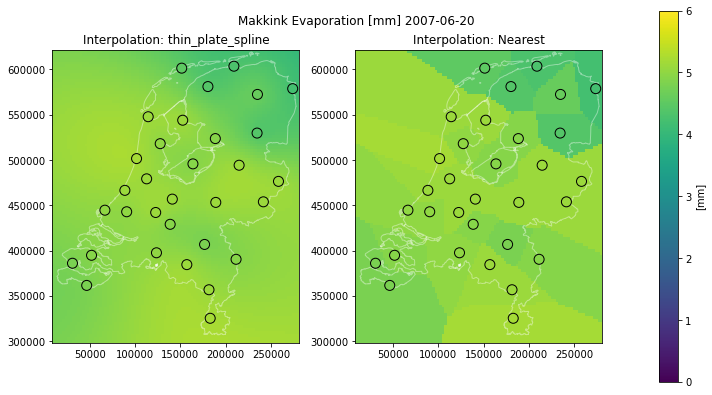

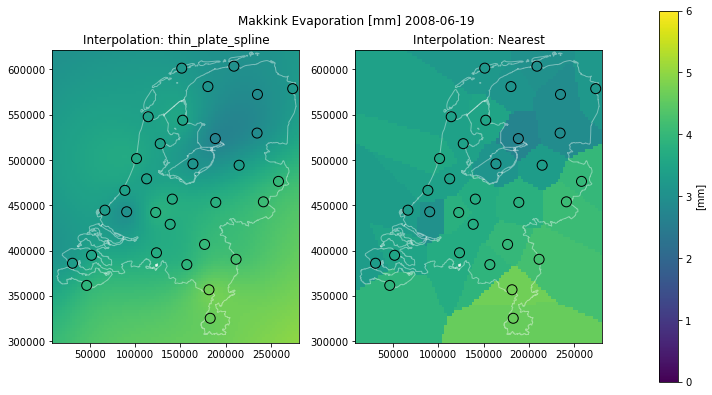

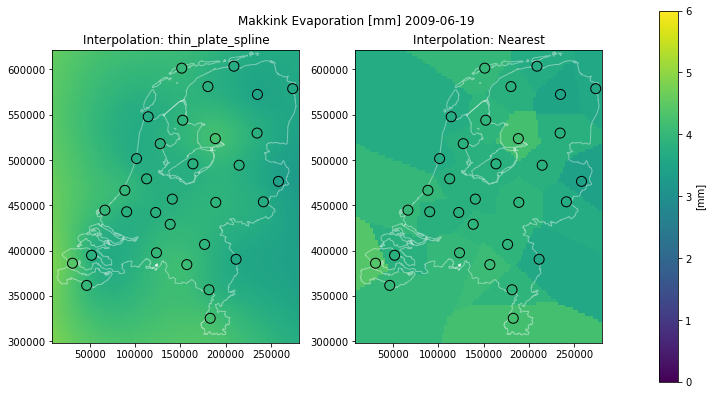

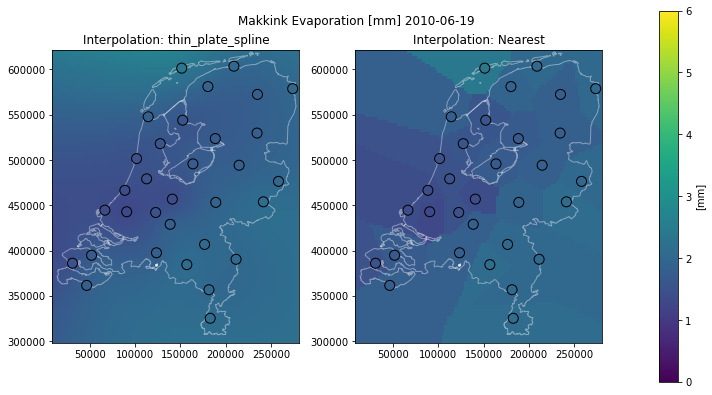

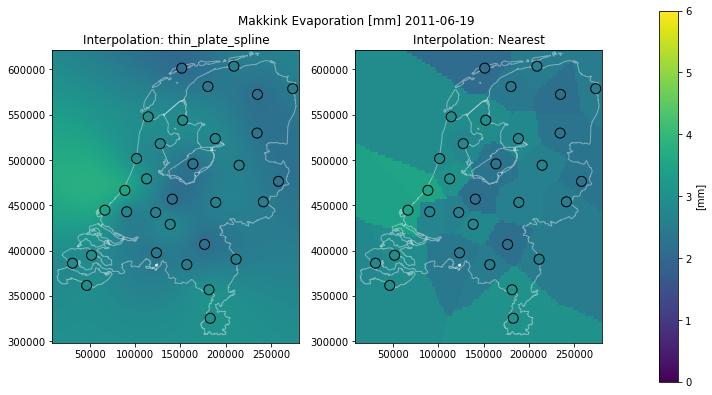

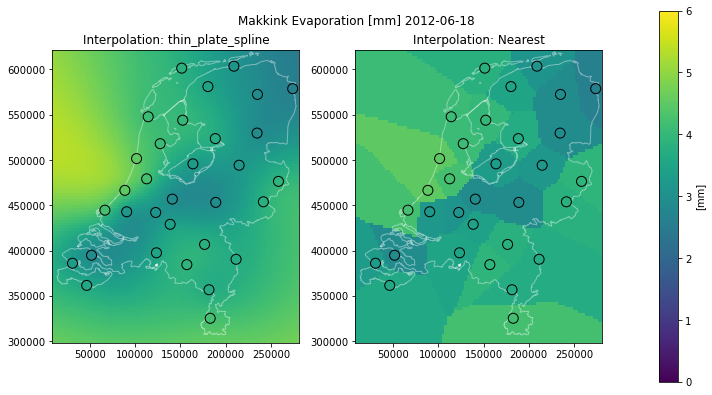

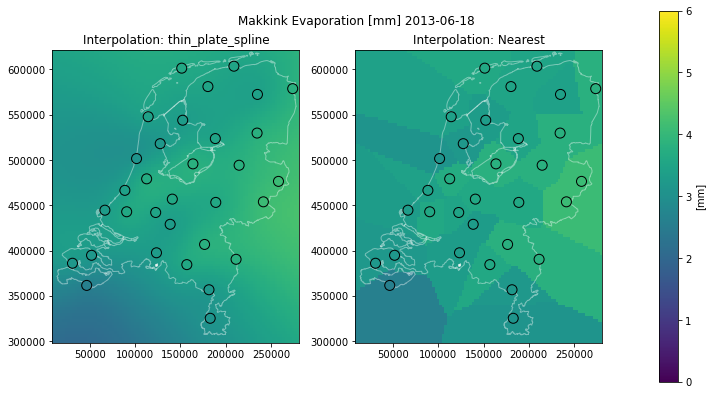

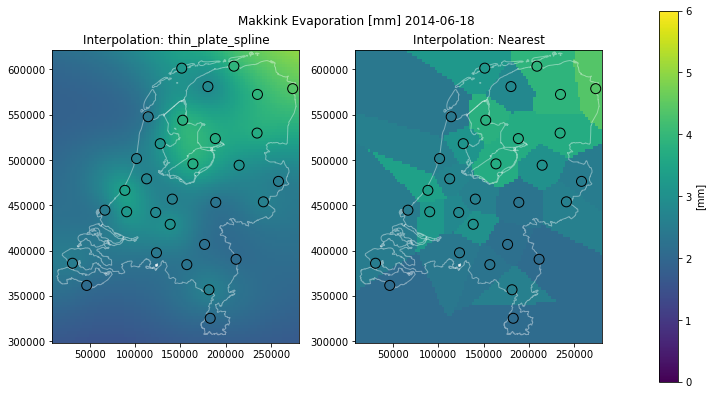

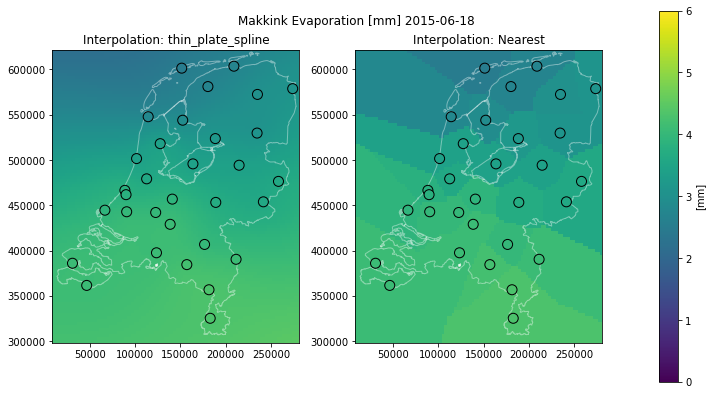

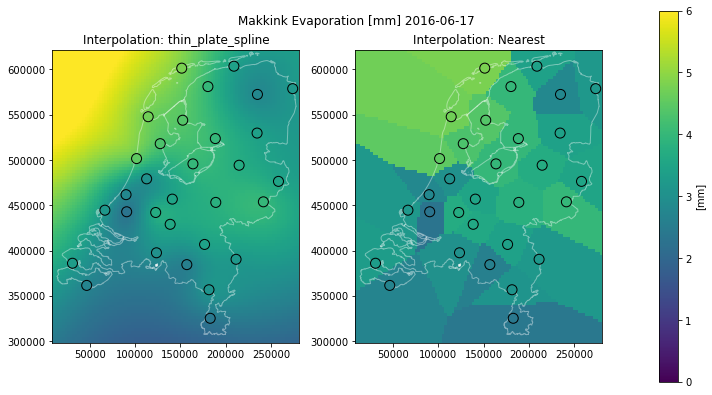

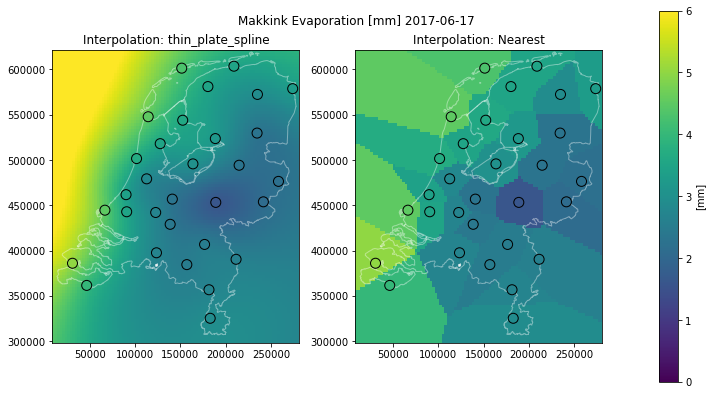

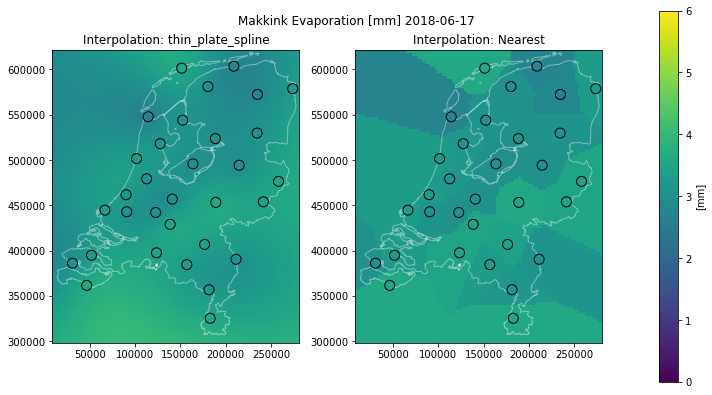

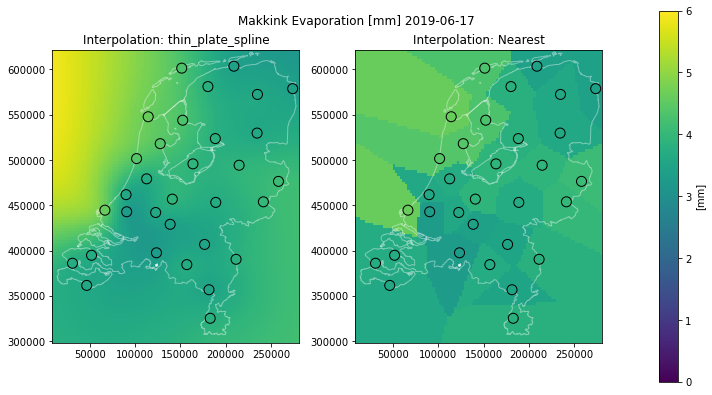

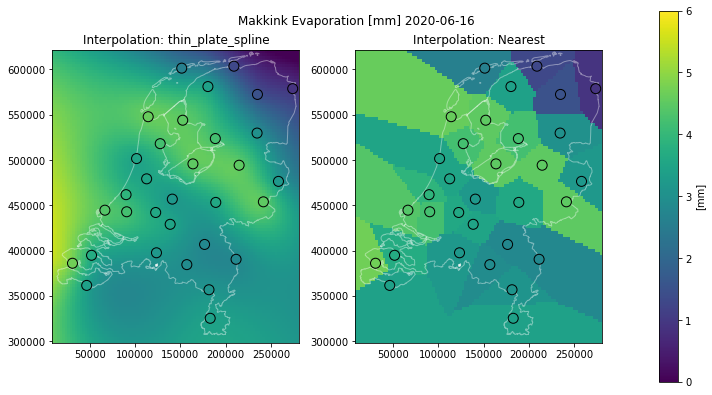

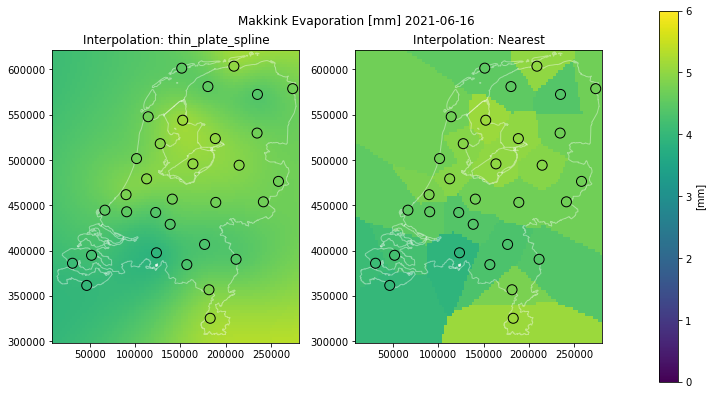

In [5]:
xy = stns.loc[df.columns, ['x', 'y']]

for idx in tqdm(df.index[0:len(df):365*10]): 
    # get all stations with values for this date
    val = df.loc[idx].dropna() * 1000 #mm
    # get stations for this date
    coor = xy.loc[val.index].to_numpy()
    if len(val) < 3: # if there are less than 3 stations, thin plate spline does not work
         kernel = 'linear'
    else:
        kernel = 'thin_plate_spline' 
        # options:
        # 'inverse_quadratic', 'linear', 'multiquadric', 'gaussian', 
        # 'inverse_multiquadric', 'cubic', 'quintic', 'thin_plate_spline'

    # create an scipy interpolator
    rbf = RBFInterpolator(coor, val.to_numpy(), epsilon=1, kernel=kernel)
    
    nea = NearestNDInterpolator(coor, val.to_numpy())
    
    # interpolate on grid of the Netherlands
    grid = np.mgrid[10000:280000:100j, 300000:620000:100j]
    grid2 = grid.reshape(2, -1).T # interpolator only takes array [[x0, y0],
                                                                #  [x1, y1]]
    val_rbf = rbf.__call__(grid2).reshape(100, 100)
    val_nea = nea.__call__(grid2).reshape(100, 100)
    
    # create figure
    fig, ax = plt.subplot_mosaic('AAAABBBBC', figsize=(10,5.925))
    fig.suptitle(f'Makkink Evaporation [mm] {idx.date()}', y=0.9)
    vmin = 0
    vmax = 6

    ax['A'].set_title(f'Interpolation: {kernel}')
    ax['A'].pcolormesh(*grid, val_rbf, vmin=vmin, vmax=vmax)
    
    nl.plot(ax=ax['A'], linewidth=1, color='w', zorder=1, alpha=0.4)

    ax['B'].set_title(f'Interpolation: Nearest')
    ax['B'].pcolormesh(*grid, val_nea, vmin=vmin, vmax=vmax)
    nl.plot(ax=ax['B'], linewidth=1, color='w', zorder=1, alpha=0.4)
    ax['A'].scatter(*coor.T, c=val, s=100, ec='k', vmin=vmin, vmax=vmax)
    p = ax['B'].scatter(*coor.T, c=val, s=100, ec='k', vmin=vmin, vmax=vmax)
    cb = fig.colorbar(p, cax=ax['C'])
    cb.set_label('[mm]')
    fig.tight_layout()